![Imagen de WhatsApp 2024-12-10 a las 14.08.43_387ecc21.jpg](<attachment:Imagen de WhatsApp 2024-12-10 a las 14.08.43_387ecc21.jpg>)
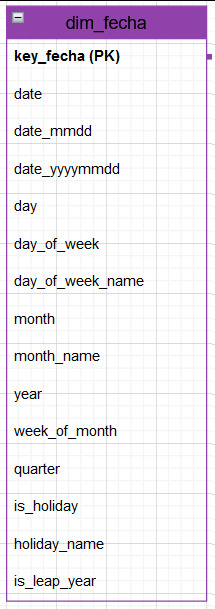

## Importar librerías

In [ ]:
from datetime import datetime # Tiempo actual
import pandas as pd # Manipulacion de datos
import sqlalchemy as sa # Conexon a la BD
import utils.conn_tools as ct  # Util para la configuracion de la BD
import holidays # Para obtener los días festivos

## Conexión con base de datos

In [ ]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

print(config_src)
print(config_etl)

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

## Extract

## Transform: Creación de la dimensión

### Fecha completa sin hora

In [ ]:
# 2009-01-04 is YYYY-MM-DD
dim_fecha = pd.DataFrame({"date" : pd.date_range(start="2023-01-01", end="2024-10-30", freq="D")})
dim_fecha

### Extraer detalles de fecha (año, mes, dia, dia de la semana...)

In [ ]:
dim_fecha["date_mmdd"] = dim_fecha["date"].dt.strftime("%m/%d")
dim_fecha["date_yyyymmdd"] = dim_fecha["date"].dt.strftime("%Y/%m/%d")

dim_fecha["day"] = dim_fecha["date"].dt.day
dim_fecha['day_of_week'] = dim_fecha['date'].dt.dayofweek
dim_fecha['day_of_week_name'] = dim_fecha['date'].dt.day_name().str.lower()

dim_fecha['month'] = dim_fecha['date'].dt.month
dim_fecha["month_name"] = dim_fecha['date'].dt.month_name().str.lower()

dim_fecha['year'] = dim_fecha['date'].dt.year 

dim_fecha["week_of_month"] = (dim_fecha["date"].dt.day - 1) // 7 + 1

dim_fecha["quarter"] = dim_fecha["date"].dt.quarter


# Festivos con libreria Holidays
co_holidays = holidays.CO(language="es")  # Objeto con festivos en Colombia
dim_fecha["is_holiday"] = dim_fecha["date"].apply(
    lambda x: x in co_holidays
)  
dim_fecha["holiday_name"] = dim_fecha["date"].apply(lambda x: co_holidays.get(x, None))

dim_fecha['is_leap_year'] = dim_fecha['date'].dt.is_leap_year

dim_fecha

## Load

In [ ]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

dim_fecha_table = sa.Table(
    "dim_fecha",
    metadata,
    # Primary key
    sa.Column("key_fecha", sa.Integer, primary_key=True, autoincrement=True),
    # Dimension keys
    sa.Column("date", sa.Date, nullable=False),
    sa.Column("date_mmdd", sa.String, nullable=False),
    sa.Column("date_yyyymmdd", sa.String, nullable=False),
    sa.Column("day", sa.Integer, nullable=False),
    sa.Column("day_of_week", sa.Integer, nullable=False),
    sa.Column("day_of_week_name", sa.String, nullable=False),
    sa.Column("month", sa.Integer, nullable=False),
    sa.Column("month_name", sa.String, nullable=False),
    sa.Column("year", sa.Integer, nullable=False),
    sa.Column("week_of_month", sa.Integer, nullable=False),
    sa.Column("quarter", sa.Integer, nullable=False),
    # Times in minutes
    sa.Column("is_holiday", sa.Boolean, nullable=False),
    sa.Column("holiday_name", sa.String, nullable=True),
    sa.Column("is_leap_year", sa.Boolean, nullable=False),
)

metadata.create_all(engine_etl)

In [ ]:
dim_fecha.to_sql(
    name="dim_fecha",
    con=engine_etl,
    if_exists="append", # Create table if not exists, else append
    index=False, # Do not create index because we already have one PK
)